In [254]:
from os.path import join as pjoin
import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau

# Содержание

- Файл simpson-set.tar.gz: Это набор данных изображений: 20 папок (по одной для каждого персонажа) с 400-2000 изображениями в каждой папке.
- Файл simpson-test-set.zip. : Предварительный просмотр набора данных изображения
- Файл weights.best.h5 : рассчитанные веса для прогнозирования в ядрах.
- Файл annotation.txt: файл аннотации для ограничивающих рамок для каждого символа.

# ----- Программа ------

# Констатанты

In [255]:
# папка откуда берем дата сет
SRC_FOLDER_DATA_SET = "data/simpsons_dataset/"
SRC_FOLDER_DATA_SET_TEST_IMAGE = "data/simpsons_dataset/sideshow_bob\pic_0167.jpg"

MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]

CLASSES = ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 
           'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 
           'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 
           'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 
           'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 
           'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']

print(len(CLASSES))

IS_SHOW_RESULT_TRAIN = 5
IS_SHOW_LOGS = False

42


In [256]:
# ===================== Конфигурация девайса
# поддержка графического процессора
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Гипер-параметры

In [257]:
EPOCHS = 25
LEARNING_RATE = 0.009
BATCH_SIZE = 128

# Изменение изображения

In [258]:
# ===================== Подготовка изображения
# Обработка входного изображения:
transform_image = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM), torch.Tensor(MEAN_IMAGE_STD))
])


# Функции

In [259]:

# считать изображения для дата сета full
def get_full_data_set():
    full_dataset = torchvision.datasets.ImageFolder(root=SRC_FOLDER_DATA_SET, transform=transform_image)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [0.9, 0.1])
    
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    valid_dataloader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    
    # test_dataloader = torch.utils.data.DataLoader(
    #     dataset=test_dataset,
    #     batch_size=BATCH_SIZE,
    #     shuffle=True,
    #     num_workers=4,
    # )
    return train_dataloader, valid_dataloader

# отображение изображений
def print_result_sep_data(data, size):
    plt.figure(figsize=(10, 10))
    for index in range(size):
        plt.subplot(5, 5, index + 1)
        # plt.tight_layout()
        plt.imshow(data[index][0], cmap='gray', interpolation='none')
        # plt.imshow(data[index][0])
    plt.show()

# Работа с дата сетом

In [260]:
train_data, valid_data = get_full_data_set()
batch, _ = next(iter(train_data))

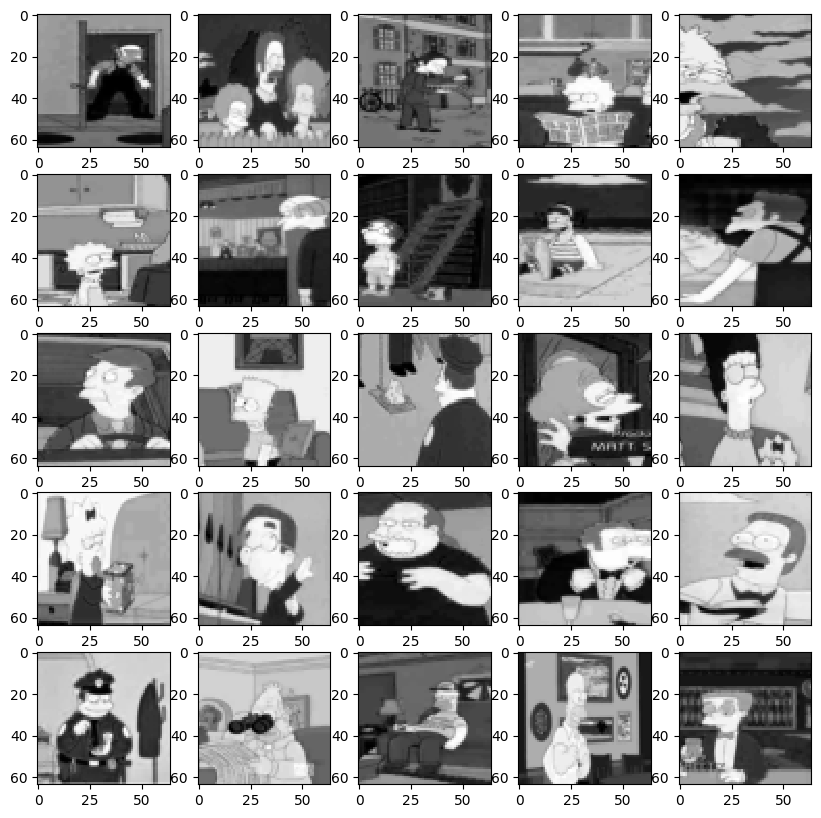

In [261]:
print_result_sep_data(batch, 25) # вывод картинок для себя

In [262]:
# определяем изначальный размер картинки для определения стартового размера слоя
imageTest = batch
print(imageTest.shape)

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

x = conv1(imageTest)
print(f'1 {x.shape}')
x = pool(x)
print(f'2 {x.shape}')
x = conv2(x)
print(f'3 {x.shape}')
x = pool(x)
print(f'4 {x.shape}')

# тогда получаем стартовый размер 
start_size_conv = 512*2 #16*13*13
print(f'start_size_conv {start_size_conv}')


torch.Size([128, 3, 64, 64])
1 torch.Size([128, 6, 60, 60])
2 torch.Size([128, 6, 30, 30])
3 torch.Size([128, 16, 26, 26])
4 torch.Size([128, 16, 13, 13])
start_size_conv 1024


# Модель

In [263]:
class ConvNet(nn.Module):    
    def __init__(self):
        # первый цвет
        super(ConvNet, self).__init__()
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(3, 6, 5),
        #     nn.BatchNorm2d(6),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2,2)
        # )
        
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(6, 16, 5),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2,2)
        # )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 512, 5),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.fc1 = nn.Linear(start_size_conv, len(CLASSES))
        # self.fc2 = nn.Linear(512, len(CLASSES))
        # self.fc3 = nn.Linear(128, len(CLASSES))
        # self.fc4 = nn.Linear(64, len(CLASSES))
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.view(-1, start_size_conv) # сплющели
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        return x

# создали модель
model = ConvNet().to(device)
# print(model)
print(torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [128, 42]                 --
├─Sequential: 1-1                        [128, 64, 30, 30]         --
│    └─Conv2d: 2-1                       [128, 64, 60, 60]         4,864
│    └─BatchNorm2d: 2-2                  [128, 64, 60, 60]         128
│    └─ReLU: 2-3                         [128, 64, 60, 60]         --
│    └─MaxPool2d: 2-4                    [128, 64, 30, 30]         --
├─Sequential: 1-2                        [128, 128, 13, 13]        --
│    └─Conv2d: 2-5                       [128, 128, 26, 26]        204,928
│    └─BatchNorm2d: 2-6                  [128, 128, 26, 26]        256
│    └─ReLU: 2-7                         [128, 128, 26, 26]        --
│    └─MaxPool2d: 2-8                    [128, 128, 13, 13]        --
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─Conv2d: 2-9                       [128, 512, 9, 9]          1,638,91

# Обучение

In [264]:
# создали потери (кроссэнтропия так как у нас много классовая классификация) тут же и совт макс
criterion = nn.CrossEntropyLoss()
# создали оптимизатор стахастический градиентный спуск - получаем скорость обучения
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min')

len_steps = len(train_data)
list_loos = []
# обучение
for epoch in range(EPOCHS):
    list_loos_epoch = []
    # перегрузчик, что бы получить разные партии
    for i, (images, labels) in enumerate(train_data):
        # получаем поддержку графического процессора
        images = images.to(device)
        labels = labels.to(device)
        
        # проходим вперед
        outputs = model(images)
        
        # создаем потери
        loss = criterion(outputs, labels)
        list_loos_epoch.append(loss.item())
        # scheduler.step(loss, epoch) # lr <
        
        # чистка градиента
        optimizer.zero_grad()
        
        # обратный проход
        loss.backward()
        
        # оптимизируем шаг
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{EPOCHS}], step [{i+1}/{len_steps}], loss {loss.item():.4f}')
    
    list_loos.append(sum(list_loos_epoch) / float(len(list_loos_epoch)))

print("finish")

Epoch [1/25], step [1/148], loss 3.8441
Epoch [1/25], step [2/148], loss 3.6339
Epoch [1/25], step [3/148], loss 3.5754
Epoch [1/25], step [4/148], loss 3.4463
Epoch [1/25], step [5/148], loss 3.3928
Epoch [1/25], step [6/148], loss 3.3504
Epoch [1/25], step [7/148], loss 3.3714
Epoch [1/25], step [8/148], loss 3.2896
Epoch [1/25], step [9/148], loss 2.9786
Epoch [1/25], step [10/148], loss 2.9804
Epoch [1/25], step [11/148], loss 3.1120
Epoch [1/25], step [12/148], loss 3.0587
Epoch [1/25], step [13/148], loss 2.8694
Epoch [1/25], step [14/148], loss 2.8905
Epoch [1/25], step [15/148], loss 2.9261
Epoch [1/25], step [16/148], loss 2.9172
Epoch [1/25], step [17/148], loss 2.8739
Epoch [1/25], step [18/148], loss 2.9894
Epoch [1/25], step [19/148], loss 2.8849
Epoch [1/25], step [20/148], loss 2.9277
Epoch [1/25], step [21/148], loss 2.8125
Epoch [1/25], step [22/148], loss 2.8376
Epoch [1/25], step [23/148], loss 2.9765
Epoch [1/25], step [24/148], loss 2.9126
Epoch [1/25], step [25/14

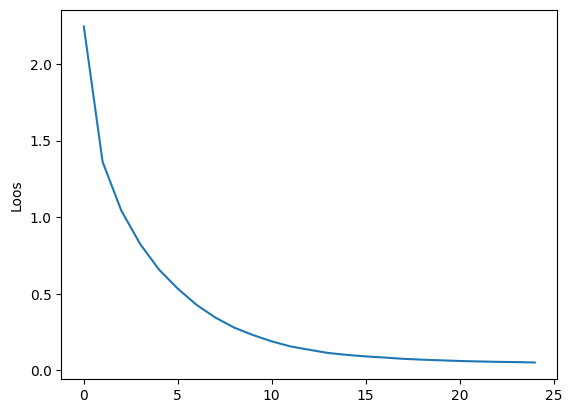

In [265]:
plt.plot([i for i in range(0, EPOCHS)], list_loos)
plt.ylabel('Loos')
plt.show()

# Проверка точности

In [266]:
# вычисление точности всей сети
list_acc = []
list_recall = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class__correct = [0 for i in range(len(CLASSES))]
    n_class__samples = [0 for i in range(len(CLASSES))]
    
    for images, labels in valid_data:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # максимальное значение индекс
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class__correct[label] += 1
            n_class__samples[label] += 1
            
    acc = 100 * n_correct / n_samples
    print(f'Accuracy of the network {acc} %\n\n')
    
    # вычисление точности для классов
    for i in range(len(CLASSES)):
        if (n_class__correct[i] != 0):
            acc = 100 * n_class__correct[i] / n_class__samples[i]
            print(f'Accuracy of {CLASSES[i]} {acc} %')
        else:
            acc = 0
            print(f'Accuracy of {CLASSES[i]} {acc} %')
        list_acc.append(acc)

Accuracy of the network 82.84758719541328 %


Accuracy of abraham_grampa_simpson 83.50515463917526 %
Accuracy of agnes_skinner 0 %
Accuracy of apu_nahasapeemapetilon 93.84615384615384 %
Accuracy of barney_gumble 43.75 %
Accuracy of bart_simpson 77.14285714285714 %
Accuracy of carl_carlson 40.0 %
Accuracy of charles_montgomery_burns 77.47747747747748 %
Accuracy of chief_wiggum 94.25287356321839 %
Accuracy of cletus_spuckler 50.0 %
Accuracy of comic_book_guy 78.37837837837837 %
Accuracy of disco_stu 0 %
Accuracy of edna_krabappel 85.41666666666667 %
Accuracy of fat_tony 25.0 %
Accuracy of gil 0 %
Accuracy of groundskeeper_willie 66.66666666666667 %
Accuracy of homer_simpson 83.10502283105023 %
Accuracy of kent_brockman 93.87755102040816 %
Accuracy of krusty_the_clown 90.9090909090909 %
Accuracy of lenny_leonard 83.87096774193549 %
Accuracy of lionel_hutz 0 %
Accuracy of lisa_simpson 86.23188405797102 %
Accuracy of maggie_simpson 47.05882352941177 %
Accuracy of marge_simpson 93.6507936507

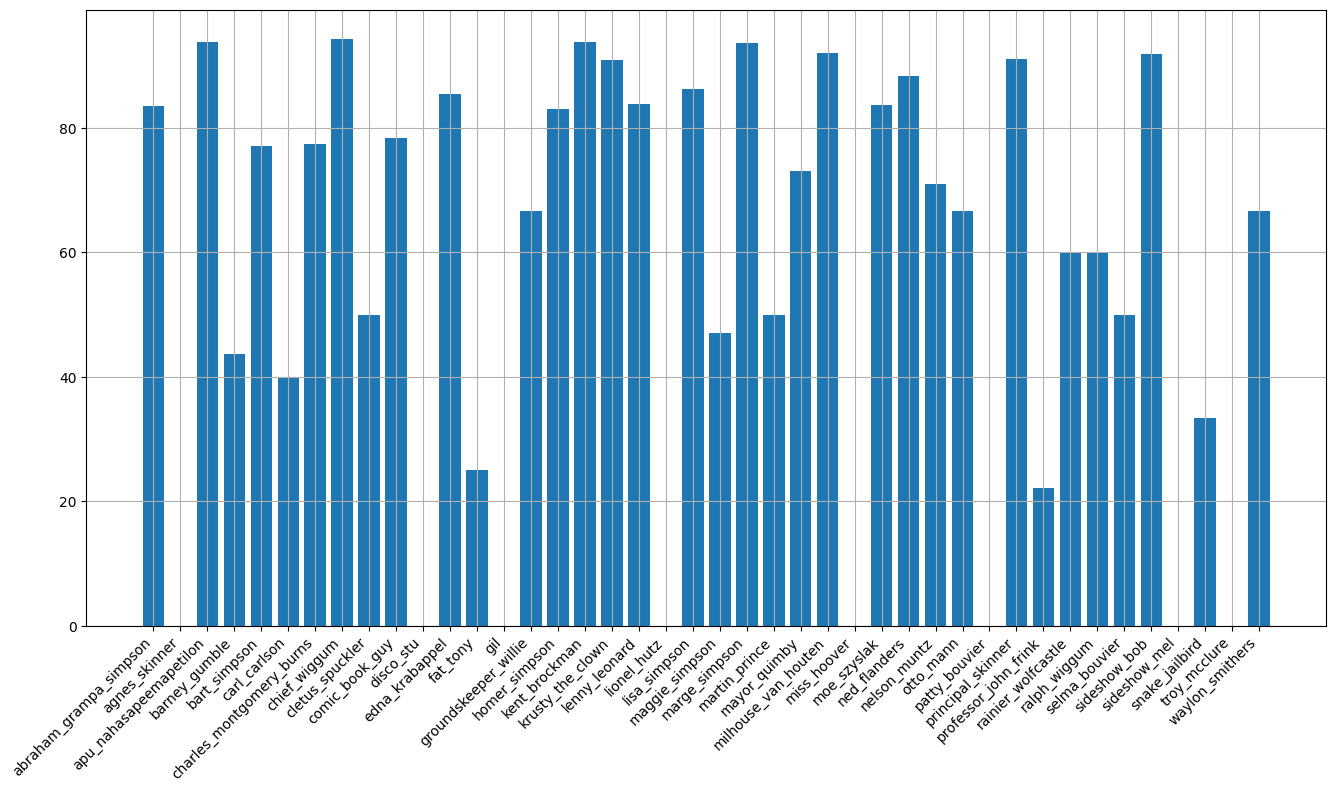

In [267]:
fig = plt.figure(figsize=(16, 8))

plt.bar(CLASSES, list_acc)
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.show()

In [268]:
    #     self.conv1 = nn.Sequential(
    #         nn.Conv2d(3, 64, 5),
    #         nn.BatchNorm2d(64),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv2 = nn.Sequential(
    #         nn.Conv2d(64, 32, 5),
    #         nn.BatchNorm2d(32),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv3 = nn.Sequential(
    #         nn.Conv2d(32, 16, 5),
    #         nn.BatchNorm2d(16),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.fc1 = nn.Linear(start_size_conv, 512)
    #     self.fc2 = nn.Linear(512, 128)
    #     self.fc3 = nn.Linear(128, 64)
    #     self.fc4 = nn.Linear(64, len(CLASSES))
        
    # def forward(self, x: torch.Tensor):
    #     x = self.conv1(x)
    #     x = self.conv2(x)
    #     x = self.conv3(x)
        
    #     x = x.view(-1, start_size_conv) # сплющели
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = F.relu(self.fc3(x))
    #     x = self.fc4(x)
    #     return x
    
    # 50 gпроцентов без 3го, за 10 итераций, за 10 с двумя